##DTSA 5511: Introduction to Deep Learning

#Purpose:
The purpose/ goal of this mini project is to create a large language model that reviews tweets from Twitter to better determine natural disasters.
By making specific language as vectors, we can determine if individuals are announcing a disaster in their area or not.
In this model I  will use a Gated Recurrent Unit (GRU) model (which is a type of recurrent neural network RNN) to ensure the model is efficient and to mitigate the problems of vanishing and exploding gradients.
Vanilla RNN's are not the best due to the exploding and vanishing gradient effect where the weight can increase exponentially or go to zero during early training. I decided to utilize a gated recurrent units instead of LSTM to mitigate the exploding/vanishing gradient problem, because it has fewer parameters and therefore, is a faster/more efficient approach for this problem. The GRU will likely perform as well as the LSTM and there is less risk of overfitting.

Import Data:


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your folder
data_path = '/content/drive/MyDrive/Colab Notebooks/Disaster Tweet Project/'

# Load the datasets
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

# Display basic information
print("Training Data Shape:", train_df.shape)
print("\nTraining Data Preview:")
print(train_df.head())
print("\nTarget Distribution:")
print(train_df['target'].value_counts())

print("\n" + "="*50)
print("\nTest Data Shape:", test_df.shape)
print("\nTest Data Preview:")
print(test_df.head())

print("\n" + "="*50)
print("\nSample Submission Shape:", sample_submission.shape)
print(sample_submission.head())

# Check for missing values
print("\n" + "="*50)
print("\nMissing values in training data:")
print(train_df.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data Shape: (7613, 5)

Training Data Preview:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Target Distribution:
target
0    4342
1    3271
Name: count, dtype: int64


Test Data Shape: (3263, 4)

Test Data Preview:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2    

TEXT STATISTICS BY CLASS
        text_length  word_count  avg_word_length  url_count  hashtag_count  \
target                                                                       
0         95.706817   14.704744         5.871325   0.508291       0.388761   
1        108.113421   15.167533         6.469866   0.770712       0.501987   

        mention_count  
target                 
0            0.420313  
1            0.272088  


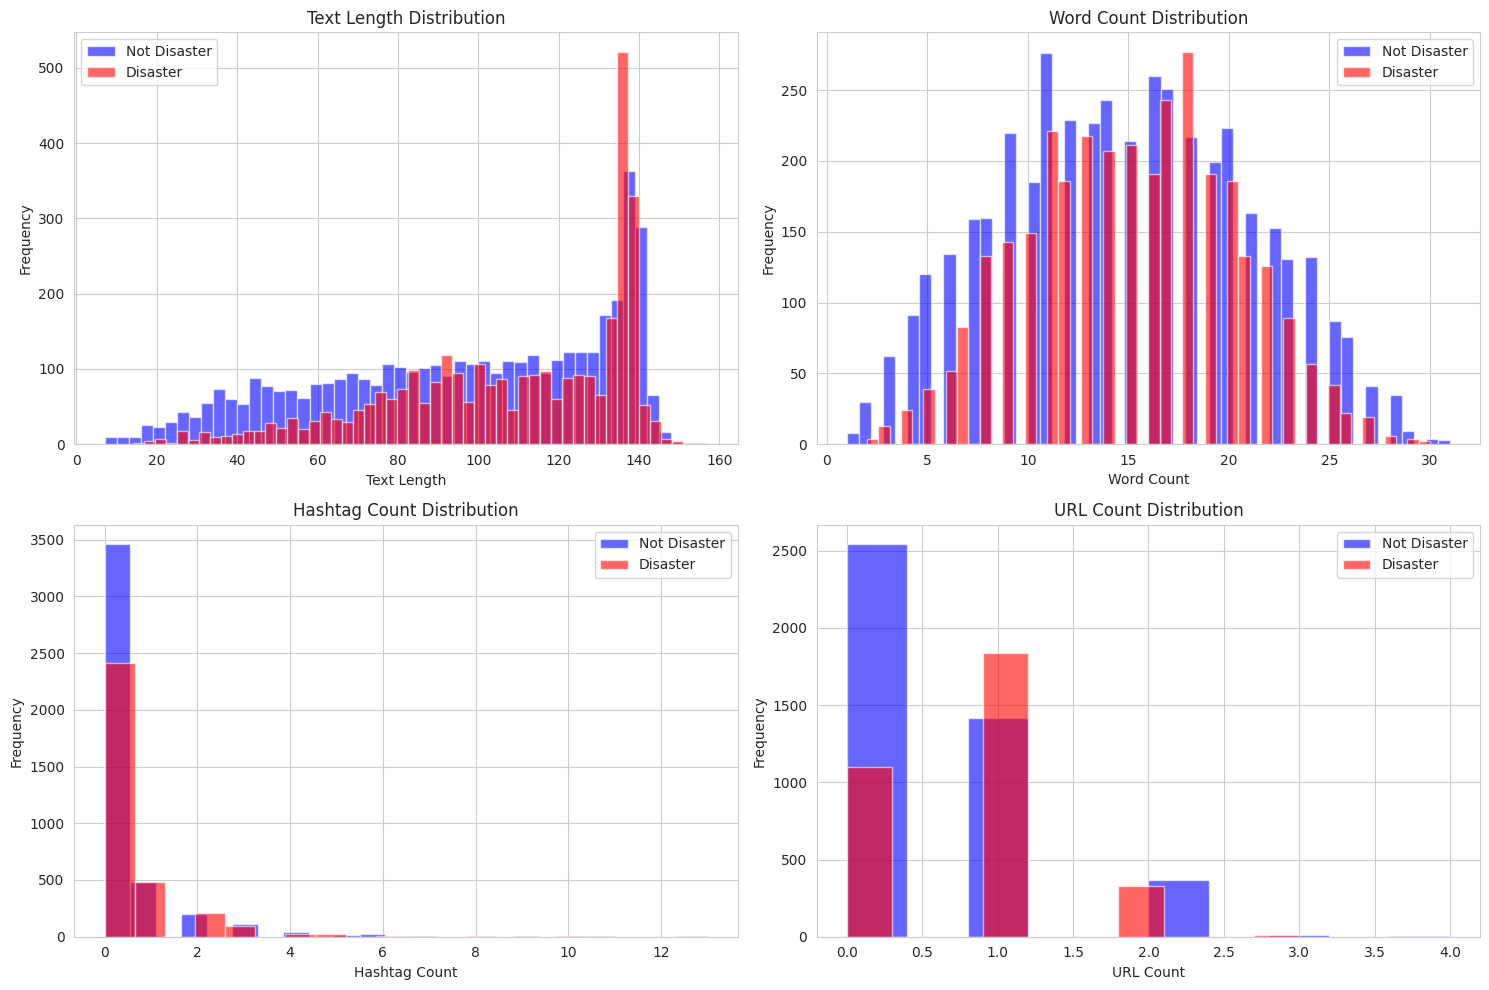


TOP 20 WORDS IN DISASTER TWEETS
the                 : 1330
and                 : 494
for                 : 394
from                : 243
with                : 188
that                : 181
after               : 181
this                : 177
are                 : 166
was                 : 165
fire                : 151
have                : 140
over                : 123
you                 : 121
more                : 121
via                 : 117
has                 : 104
suicide             : 103
who                 : 100
disaster            : 97

TOP 20 WORDS IN NON-DISASTER TWEETS
the                 : 1877
and                 : 911
you                 : 625
for                 : 486
with                : 374
that                : 357
this                : 286
like                : 250
have                : 240
are                 : 231
just                : 229
your                : 225
was                 : 216
but                 : 216
not                 : 198
out                

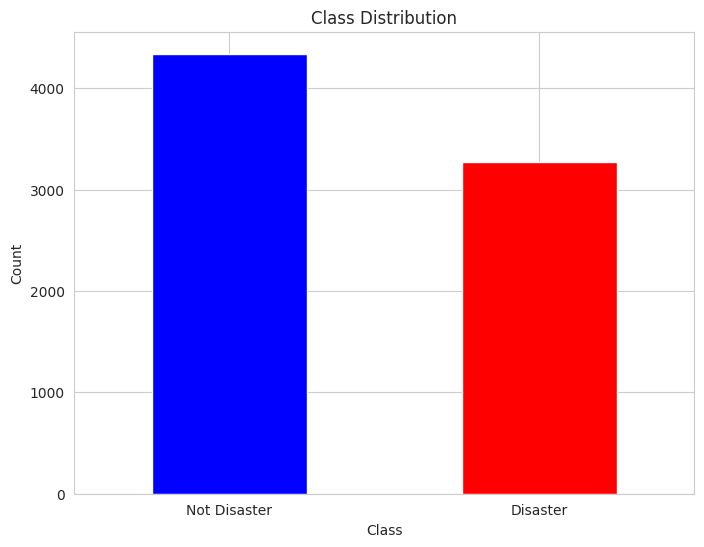

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================
# 1. BASIC TEXT STATISTICS
# ============================================

def get_text_stats(df, text_col='text'):
    """Calculate basic text statistics"""
    df['text_length'] = df[text_col].astype(str).apply(len)
    df['word_count'] = df[text_col].astype(str).apply(lambda x: len(x.split()))
    df['avg_word_length'] = df[text_col].astype(str).apply(lambda x: np.mean([len(word) for word in x.split()]))
    df['url_count'] = df[text_col].astype(str).apply(lambda x: len(re.findall(r'http\S+|www.\S+', x)))
    df['hashtag_count'] = df[text_col].astype(str).apply(lambda x: len(re.findall(r'#\w+', x)))
    df['mention_count'] = df[text_col].astype(str).apply(lambda x: len(re.findall(r'@\w+', x)))
    return df

train_df = get_text_stats(train_df)

print("=" * 60)
print("TEXT STATISTICS BY CLASS")
print("=" * 60)
print(train_df.groupby('target')[['text_length', 'word_count', 'avg_word_length',
                                    'url_count', 'hashtag_count', 'mention_count']].mean())

# ============================================
# 2. VISUALIZATIONS
# ============================================

# Distribution of text lengths by class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length distribution
axes[0, 0].hist(train_df[train_df['target']==0]['text_length'], bins=50, alpha=0.6, label='Not Disaster', color='blue')
axes[0, 0].hist(train_df[train_df['target']==1]['text_length'], bins=50, alpha=0.6, label='Disaster', color='red')
axes[0, 0].set_xlabel('Text Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(train_df[train_df['target']==0]['word_count'], bins=50, alpha=0.6, label='Not Disaster', color='blue')
axes[0, 1].hist(train_df[train_df['target']==1]['word_count'], bins=50, alpha=0.6, label='Disaster', color='red')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].legend()

# Hashtag count
axes[1, 0].hist(train_df[train_df['target']==0]['hashtag_count'], bins=20, alpha=0.6, label='Not Disaster', color='blue')
axes[1, 0].hist(train_df[train_df['target']==1]['hashtag_count'], bins=20, alpha=0.6, label='Disaster', color='red')
axes[1, 0].set_xlabel('Hashtag Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Hashtag Count Distribution')
axes[1, 0].legend()

# URL count
axes[1, 1].hist(train_df[train_df['target']==0]['url_count'], bins=10, alpha=0.6, label='Not Disaster', color='blue')
axes[1, 1].hist(train_df[train_df['target']==1]['url_count'], bins=10, alpha=0.6, label='Disaster', color='red')
axes[1, 1].set_xlabel('URL Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('URL Count Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# ============================================
# 3. MOST COMMON WORDS
# ============================================

def get_top_words(df, target_value, n=20):
    """Get most common words for a specific class"""
    texts = df[df['target'] == target_value]['text'].astype(str)
    all_words = ' '.join(texts).lower().split()
    # Remove common stopwords and special characters
    all_words = [word for word in all_words if len(word) > 2 and word.isalpha()]
    return Counter(all_words).most_common(n)

print("\n" + "=" * 60)
print("TOP 20 WORDS IN DISASTER TWEETS")
print("=" * 60)
for word, count in get_top_words(train_df, 1, 20):
    print(f"{word:20s}: {count}")

print("\n" + "=" * 60)
print("TOP 20 WORDS IN NON-DISASTER TWEETS")
print("=" * 60)
for word, count in get_top_words(train_df, 0, 20):
    print(f"{word:20s}: {count}")

# ============================================
# 4. MISSING VALUES ANALYSIS
# ============================================

print("\n" + "=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)
missing_data = train_df.isnull().sum()
missing_percent = 100 * missing_data / len(train_df)
missing_table = pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_percent})
print(missing_table[missing_table['Missing Count'] > 0])

# ============================================
# 5. KEYWORD ANALYSIS
# ============================================

print("\n" + "=" * 60)
print("KEYWORD ANALYSIS")
print("=" * 60)
print(f"Unique keywords: {train_df['keyword'].nunique()}")
print(f"Missing keywords: {train_df['keyword'].isnull().sum()}")

# Top keywords in disaster tweets
if not train_df['keyword'].isnull().all():
    disaster_keywords = train_df[train_df['target']==1]['keyword'].value_counts().head(10)
    print("\nTop 10 keywords in disaster tweets:")
    print(disaster_keywords)

# ============================================
# 6. SAMPLE TEXT VECTORS (TF-IDF)
# ============================================

from sklearn.feature_extraction.text import TfidfVectorizer

print("\n" + "=" * 60)
print("SAMPLE TEXT VECTORS (TF-IDF)")
print("=" * 60)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X_tfidf = vectorizer.fit_transform(train_df['text'].astype(str))

# Show feature names (words)
feature_names = vectorizer.get_feature_names_out()
print(f"\nVocabulary size: {len(feature_names)}")
print(f"First 20 features: {feature_names[:20]}")

# Show vectors for first 5 tweets
print("\n" + "-" * 60)
print("SAMPLE VECTORS (first 5 tweets):")
print("-" * 60)

for i in range(5):
    tweet = train_df.iloc[i]['text']
    vector = X_tfidf[i].toarray()[0]
    target = train_df.iloc[i]['target']

    print(f"\nTweet {i+1} (Label: {'DISASTER' if target == 1 else 'NOT DISASTER'}):")
    print(f"Text: {tweet[:80]}...")
    print(f"Vector shape: {vector.shape}")
    print(f"Non-zero elements: {np.count_nonzero(vector)}")

    # Show top 5 most important features for this tweet
    top_indices = vector.argsort()[-5:][::-1]
    print("Top 5 features:")
    for idx in top_indices:
        if vector[idx] > 0:
            print(f"  - {feature_names[idx]:15s}: {vector[idx]:.4f}")

# ============================================
# 7. WORD EMBEDDINGS SAMPLE (if you want to use word2vec style)
# ============================================

print("\n" + "=" * 60)
print("SAMPLE WORD VECTORS (CountVectorizer)")
print("=" * 60)

from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(max_features=50, stop_words='english')
X_count = count_vec.fit_transform(train_df['text'].astype(str))

print(f"Vocabulary: {count_vec.get_feature_names_out()[:30]}")
print(f"\nSample vector for first tweet:")
print(f"Shape: {X_count[0].toarray().shape}")
print(f"Vector: {X_count[0].toarray()}")
print(f"Non-zero indices: {X_count[0].toarray()[0].nonzero()[0]}")
print(f"Corresponding words: {[count_vec.get_feature_names_out()[i] for i in X_count[0].toarray()[0].nonzero()[0]]}")

# ============================================
# 8. CLASS BALANCE
# ============================================

print("\n" + "=" * 60)
print("CLASS BALANCE")
print("=" * 60)
class_counts = train_df['target'].value_counts()
print(class_counts)
print(f"\nClass distribution:")
print(f"Not Disaster: {class_counts[0]/len(train_df)*100:.2f}%")
print(f"Disaster: {class_counts[1]/len(train_df)*100:.2f}%")

# Plot
plt.figure(figsize=(8, 6))
train_df['target'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)
plt.show()

Preprocessing text...
Sample cleaned tweets:

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned:  our deeds are the reason of this earthquake may allah forgive us all

Original: Forest fire near La Ronge Sask. Canada
Cleaned:  forest fire near la ronge sask. canada

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned:  all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected

Vocabulary size: 17618
Training sequences shape: (7613, 100)
Test sequences shape: (3263, 100)

Sample tweet: our deeds are the reason of this earthquake may allah forgive us all
Tokenized: [114, 4483, 22, 2, 834, 6, 19, 245, 132, 1581, 4484, 84, 39]
Padded: [ 114 4483   22    2  834    6   19  245  132 1581 4484   84   39    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


TRAINING MODEL
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.6100 - auc: 0.6216 - loss: 0.6496 - precision: 0.5936 - recall: 0.1404
Epoch 1: val_accuracy improved from -inf to 0.77938, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 154s 723ms/step - accuracy: 0.6103 - auc: 0.6223 - loss: 0.6493 - precision: 0.5945 - recall: 0.1416 - val_accuracy: 0.7794 - val_auc: 0.8444 - val_loss: 0.4890 - val_precision: 0.7598 - val_recall: 0.7110 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8213 - auc: 0.8727 - loss: 0.4346 - precision: 0.8347 - recall: 0.7252
Epoch 2: val_accuracy did not improve from 0.77938
191/191 ━━━━━━━━━━━━━━━━━━━━ 138s 724ms/step - accuracy: 0.8214 - auc: 0.8728 - loss: 0.4344 - precision: 0.8349 - recall: 0.7254 - val_accuracy: 0.7781 - val_auc: 0.8521 - val_loss: 0.4782 - val_precision: 0.7476 - val_recall: 0.7294 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8774 - auc: 0.9365 - loss: 0.3084 - precision: 0.8763 - recall: 0.8305
Epoch 3: val_accuracy improved from 0.77938 to 0.78070, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 138s 723ms/step - accuracy: 0.8775 - auc: 0.9366 - loss: 0.3083 - precision: 0.8765 - recall: 0.8306 - val_accuracy: 0.7807 - val_auc: 0.8474 - val_loss: 0.5592 - val_precision: 0.7439 - val_recall: 0.7462 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9124 - auc: 0.9659 - loss: 0.2276 - precision: 0.9240 - recall: 0.8661
Epoch 4: val_accuracy did not improve from 0.78070
191/191 ━━━━━━━━━━━━━━━━━━━━ 139s 729ms/step - accuracy: 0.9125 - auc: 0.9659 - loss: 0.2275 - precision: 0.9241 - recall: 0.8662 - val_accuracy: 0.7380 - val_auc: 0.8322 - val_loss: 0.6988 - val_precision: 0.6641 - val_recall: 0.7890 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9386 - auc: 0.9784 - loss: 0.1757 - precision: 0.9349 - recall: 0.9215
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy did not improve from 0.78070
191/191 ━━━━━━━━━━━━━━━━━

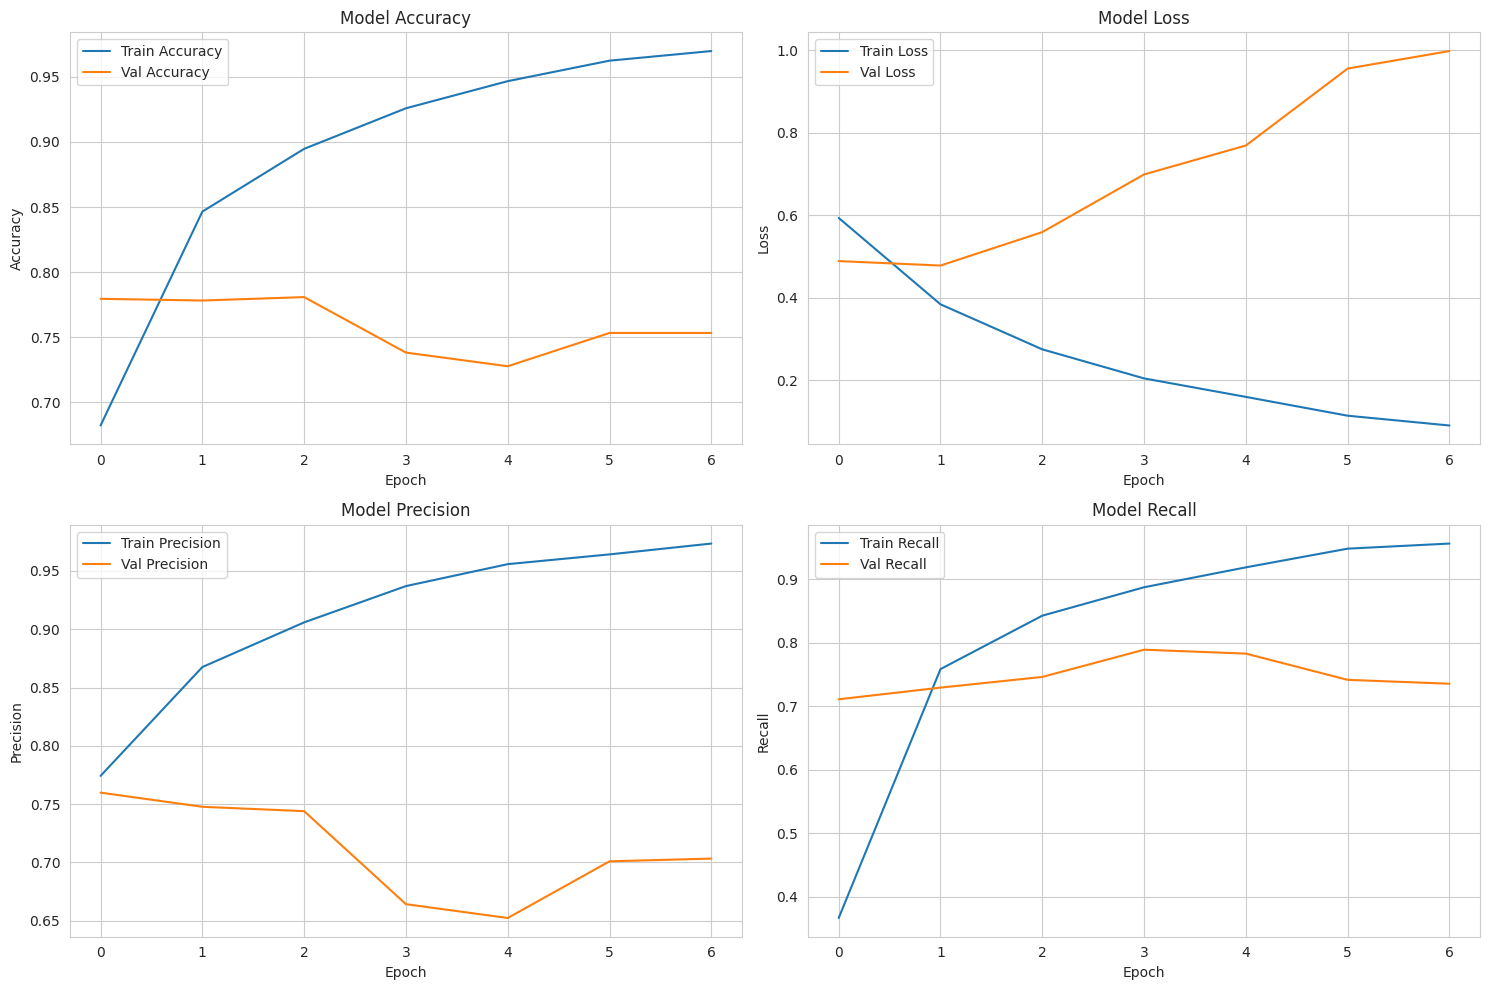


EVALUATION ON VALIDATION SET
Validation Loss: 0.4782
Validation Accuracy: 0.7781
Validation Precision: 0.7476
Validation Recall: 0.7294
Validation AUC: 0.8521
F1-Score: 0.7384
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

Not Disaster       0.80      0.81      0.81       869
    Disaster       0.75      0.73      0.74       654

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



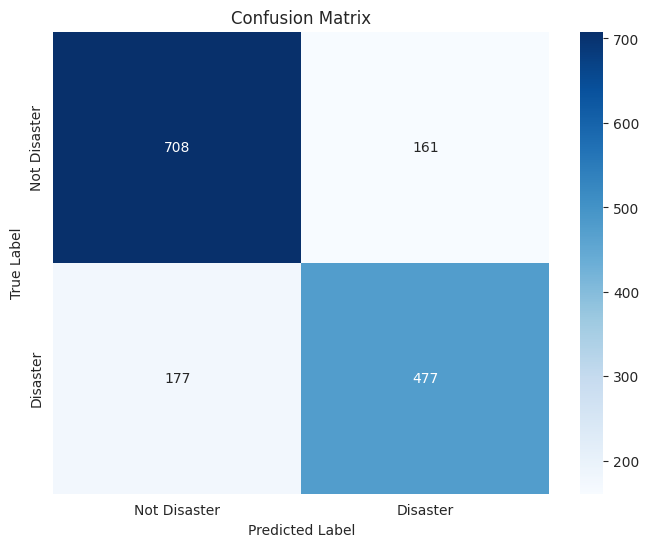


MAKING PREDICTIONS ON TEST SET
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step
Predictions shape: (3263,)
Sample predictions: [1 1 1 1 1 1 0 0 0 0]

Submission preview:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0

Submission saved to 'submission.csv'

TESTING WITH CUSTOM TWEETS

Tweet: Just heard a massive explosion downtown! Building on fire!
Prediction: DISASTER (confidence: 0.9663)

Tweet: I love spending time with my family on weekends
Prediction: NOT DISASTER (confidence: 0.0940)

Tweet: Earthquake alert! Everyone stay safe and seek shelter
Prediction: DISASTER (confidence: 0.8631)

Tweet: Having a great time at the beach today
Prediction: NOT DISASTER (confidence: 0.2525)

Tweet: Tornado warning in effect for the next 2 hours
Prediction: DISASTER (confidence: 0.9762)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# 1. TEXT PREPROCESSING
# ============================================

def preprocess_text(text):
    """Clean and preprocess tweet text"""
    import re
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove mentions and hashtags (optional - you can keep hashtags if useful)
    # text = re.sub(r'@\w+', '', text)
    # text = re.sub(r'#\w+', '', text)
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s!?.,]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
print("Preprocessing text...")
train_df['cleaned_text'] = train_df['text'].astype(str).apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].astype(str).apply(preprocess_text)

print("Sample cleaned tweets:")
for i in range(3):
    print(f"\nOriginal: {train_df.iloc[i]['text']}")
    print(f"Cleaned:  {train_df.iloc[i]['cleaned_text']}")

# ============================================
# 2. TOKENIZATION AND PADDING
# ============================================

# Hyperparameters
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 100      # Maximum sequence length
EMBEDDING_DIM = 128

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Get labels
y_train = train_df['target'].values

print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Training sequences shape: {X_train_padded.shape}")
print(f"Test sequences shape: {X_test_padded.shape}")

# Show sample sequence
print(f"\nSample tweet: {train_df.iloc[0]['cleaned_text']}")
print(f"Tokenized: {X_train_seq[0]}")
print(f"Padded: {X_train_padded[0]}")

# ============================================
# 3. TRAIN-VALIDATION SPLIT
# ============================================

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_padded, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"\nTraining set size: {len(X_train_final)}")
print(f"Validation set size: {len(X_val)}")

# ============================================
# 4. BUILD GRU MODEL
# ============================================

def create_gru_model(vocab_size, embedding_dim, max_len):
    """Create a GRU-based model for text classification"""

    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_len,
                  name='embedding'),

        # Spatial dropout for regularization
        SpatialDropout1D(0.2),

        # Bidirectional GRU layers
        Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        Bidirectional(GRU(32, dropout=0.2, recurrent_dropout=0.2)),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    return model

# Create model
model = create_gru_model(MAX_WORDS, EMBEDDING_DIM, MAX_LEN)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

# Print model summary
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()

# ============================================
# 5. CALLBACKS
# ============================================

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint
checkpoint = ModelCheckpoint(
    'best_gru_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ============================================
# 6. TRAIN MODEL
# ============================================

print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)

BATCH_SIZE = 32
EPOCHS = 20

history = model.fit(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ============================================
# 7. PLOT TRAINING HISTORY
# ============================================

def plot_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

# ============================================
# 8. EVALUATE MODEL
# ============================================

print("\n" + "="*60)
print("EVALUATION ON VALIDATION SET")
print("="*60)

val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"F1-Score: {2 * (val_precision * val_recall) / (val_precision + val_recall):.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_proba = model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_val, y_pred, target_names=['Not Disaster', 'Disaster']))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ============================================
# 9. MAKE PREDICTIONS ON TEST SET
# ============================================

print("\n" + "="*60)
print("MAKING PREDICTIONS ON TEST SET")
print("="*60)

test_predictions_proba = model.predict(X_test_padded)
test_predictions = (test_predictions_proba > 0.5).astype(int).flatten()

print(f"Predictions shape: {test_predictions.shape}")
print(f"Sample predictions: {test_predictions[:10]}")

# ============================================
# 10. CREATE SUBMISSION FILE
# ============================================

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

print("\nSubmission preview:")
print(submission.head(10))

# Save submission
submission.to_csv('submission.csv', index=False)
print("\nSubmission saved to 'submission.csv'")

# ============================================
# 11. TEST ON SAMPLE TWEETS
# ============================================

def predict_tweet(tweet_text, model, tokenizer, max_len):
    """Predict if a tweet is about a disaster"""
    # Preprocess
    cleaned = preprocess_text(tweet_text)
    # Tokenize
    sequence = tokenizer.texts_to_sequences([cleaned])
    # Pad
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    # Predict
    prediction = model.predict(padded, verbose=0)[0][0]

    return prediction, "DISASTER" if prediction > 0.5 else "NOT DISASTER"

# Test with custom examples
print("\n" + "="*60)
print("TESTING WITH CUSTOM TWEETS")
print("="*60)

test_tweets = [
    "Just heard a massive explosion downtown! Building on fire!",
    "I love spending time with my family on weekends",
    "Earthquake alert! Everyone stay safe and seek shelter",
    "Having a great time at the beach today",
    "Tornado warning in effect for the next 2 hours"
]

for tweet in test_tweets:
    prob, label = predict_tweet(tweet, model, tokenizer, MAX_LEN)
    print(f"\nTweet: {tweet}")
    print(f"Prediction: {label} (confidence: {prob:.4f})")

## Discussion, Results and Conclusion:

This mini project implemented a Bidirectional GRU (Gated Recurrent Unit) neural network for binary classification of disaster-related tweets. The bidirection GRU approach allowed the model to capture context from both directions in the tweet, which is important for understanding the context of each post. The data cleaning section in the EDA was important to ensure that the the text was normalized, there wasn't any special characters and all of the urls were removed. This helped ensure that there was not unneessary noise that the model would pick up on.
The model was trained on 6,090 tweets and validated on 1,523 tweets.

The final results indicated that the model performed fairly well. The validation precision was 74.76%, while the validation accuracy was 77.81%. The final AUC score was 85.21% which means that it is pretty good at distinguishing between disaster vs. non-disaster tweets. The final F1 score was 73.84%, indicating that there was a good balance between precision and recall. Although a transformation approach could have also worked for this large language model, it was not in the scope of the class lectures for week 4. Using a transformer based model instead of a GRU would have likely resulted in a higher F1 score and final AUC score. Transformers are different than GRU in that they look at all of the words in a text at once to understand the relationships better. This ultimately helps the LM learn the context of the sentence. Gated recurrent units on the other hand read through a sentence sequentially. Therefore, they only read one word at a time in each tweet. Overall, I do think this model was a good starting model for disaster tweet classification.